In [6]:
import sys,os

RES_PATH = '../../../../resources'
LIB_PATH = '../../../../python_lib'

if not os.path.exists(RES_PATH):
    print( 'cannot find \COMPM080-Tutorials-2020\resources\, please update RES_PATH')
    exit(1)
else:
    print('found resources')

# append path 

sys.path.append(LIB_PATH) 
from geo_tools import rd_helper

import pyglet
pyglet.options['shadow_window'] = False

import pyrender
import numpy as np
import trimesh

import matplotlib
import matplotlib.pyplot as plt


from sklearn.neighbors import KDTree

from copy import deepcopy
import time

import random

%load_ext autoreload
%autoreload 2

esources\, please update RES_PATH


ModuleNotFoundError: ignored

In [5]:
if not os.path.exists(RES_PATH):
    print( 'cannot find \COMPM080-Tutorials-2020\resources\, please update RES_PATH')
    exit(1)
from pathlib import Path

Path(RES_PATH).exists()

esources\, please update RES_PATH


False

## Load Meshes
create dictionary
```
bunnies[name] =
[
    "mesh": \\ The trimesh
    "vertices" \\ The point cloud
    "render_object" \\ The renderable object
]
```

In [ ]:
file_names = [
    "bun000_v2",
    "bun045_v2",
    "bun090_v2",
    "bun180_v2",
    "bun270_v2",
    "bun315_v2"
]

meshes = [trimesh.load(f"./data/{name}.ply") for name in file_names]
point_clouds = [mesh.vertices for mesh in meshes]
render_objects = [pyrender.Mesh.from_points(pcd, colors=(np.random.rand(),np.random.rand(),np.random.rand())) for pcd in point_clouds]

bunnies = {}

for i, name in enumerate(file_names):
    bunnies[name] = {"mesh":meshes[i], "vertices":point_clouds[i], "render_object":render_objects[i]}


### Define Utility functions

In [ ]:
def scene_factory(render_objects, ctx=None):
    """
    Create a scene with the render objects
    Keyword Arguments:
    ctx -- The context of the viewer. Registers ctx["nodes"] with a list of the nodes if
        ctx is not None (default: None)
    """
    scene = pyrender.Scene(ambient_light=0.5*np.array([1.0, 1.0, 1.0, 1.0]))
    pcd_nodes = [scene.add(obj) for obj in render_objects]
    
    if ctx is not None:
        ctx["nodes"] = pcd_nodes
    
    return scene

def run_gui(render_objects, ctx=None,
            key_mapping=None, render_flags=None, viewer_flags=None):
    scene = scene_factory(render_objects, ctx)
    v=pyrender.Viewer(scene, use_raymond_lighting=True,
                     registered_keys=key_mapping, render_flags=render_flags, viewer_flags=viewer_flags)
    del v

def get_trimeshes(bunny_names):
    return [trimesh.load(f"./data/{name}.ply") for name in file_names]

def get_point_clouds(bunny_names, samples=1000):
    trimeshes = get_trimeshes(bunny_names)
    return [mesh.sample(n_samples) for mesh in trimeshes]

def render_point_clouds(point_clouds,
                        colors=[(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255)],
                        ctx=None,
                        key_mapping=None,
                        render_flags=None,
                        viewer_flags=None
                       ):
    render_objects = [pyrender.Mesh.from_points(pcd, colors=c) for pcd, c in zip(point_clouds, colors)]
    run_gui(render_objects, key_mapping=key_mapping, ctx=ctx, 
            render_flags=render_flags, viewer_flags=viewer_flags)

def render_meshes(meshes, 
                  render_as_point_clouds=True,
                  colors=[(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255)],
                  ctx=None,
                  key_mapping=None,
                  render_flags=None,
                  viewer_flags=None,
                 ):
    '''
    Arguments:
        meshes -- A python list with the Trimeshes to render
    
    Keyword Arguments:
        render_as_point_clouds -- Render the mesh as a set of points (without faces). If false renders
        the trimeshes directly considering colors and normals (colors attribute is ignored.) (default: True)
        
        ctx -- Context object (dict) that can be used by the viewer callback functions.
        key_mapping -- A dictionary of bindings of keys to a callback that can be executed.
        
        colors -- A list of colors(3-tuple) for each mesh. (WARN. Ignored if render_as_point_clouds is True)
    '''
    if render_as_point_clouds:
        render_point_clouds([mesh.vertices for mesh in meshes],
                            colors=colors, ctx=ctx,
                            key_mapping=key_mapping, render_flags=render_flags, viewer_flags=viewer_flags
                           )
    else:
        render_objects = [pyrender.Mesh.from_trimesh(mesh) for mesh, c in zip(meshes, colors)]
        run_gui(render_objects, ctx=ctx, 
                key_mapping=key_mapping, render_flags=render_flags, viewer_flags=viewer_flags)

    
def render_bunnies(bunny_names, 
                   key_mapping=[],
                   colors=[(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255)],
                   ctx=None
                  ):
    render_meshes([trimesh.load(f"./data/{name}.ply") for name in bunny_names], 
                  key_mapping=key_mapping,
                  colors=colors,
                  ctx=ctx
                 )

    
def error(Q, P):
    """
    Arguments:
    Q, P -- Nx3 arrays (N vertices)
    """
    return np.sum((Q - P)**2)


def sample(mesh, return_normals=False):
    """
    Arguments:
    mesh -- (trimesh) The mesh to sample from.
    kdtree -- The kdtree of the  mesh
    """
    dst_mesh_sampled_vertices = mesh.sample(5000)
    # sample() returns generated vertices. Get the closest
    dst_mesh_sampled_vertices, vertices_to_keep_idxs = mesh.kdtree.query(dst_mesh_sampled_vertices)
        
    vertices = mesh.vertices[vertices_to_keep_idxs]
    
    if return_normals:
        normals  = mesh.vertex_normals[vertices_to_keep_idxs]
        return vertices, normals
    
    return vertices


def translate_mesh_to_origin(mesh):
    """
    Inplace translation of the mesh to origin so that it's centroid it's at the origin.
    """
    T = np.eye(4);
    T[:3, 3] = -mesh.centroid
    mesh.apply_transform(T);

def plot_results(results , number_iterations=-1, output_figure_name=None):
    """
    Plots the errors for each result in results.
    
    Keyword Arguments:
    number_iterations -- Number of iterations to plot. If -1 plots them all. (default: -1)
    output_figure_name -- If not None saves the figure with that name. (default: None)
        i.e "output.pdf"
    """
    f = plt.figure()
    plt.title('SSD error')
    plt.ylabel('error ^10x4')
    plt.xlabel('iteration')

    for i, result in enumerate(results):
        handle = plt.plot(np.asarray(result["errors"][1:number_iterations]), label=str(i))
        plt.legend()
    
    if output_figure_name is not None:
        f.savefig(output_figure_name, bbox_inches='tight')
    

## Viewer functions to render results more easily

In [ ]:
from IPython.display import clear_output
    
def get_accumulated_transform_from_result(result, iteration=-1, rowwise=True, no_cache=True):
    '''
    Returns the accumulated transform matrix for the iteration.
    Applying the accumulated transform to result["initial_mesh"] gives the
    same mesh as result["meshes"][iteration].
    
    Side effects:
        Creates "accumulated_transforms" entry in result.
        Is a list with the accumulated transform for each iteration.
        Used for caching.
        
    Arguments:
        result -- The result dictionary given from an icp run.
    Keyword arguments:
        iteration -- The iteration to get the accumulated transform. If -1 the last.(default: -1) 
    '''
    if "accumulated_transforms" not in result or no_cache:
        total_transform = result["transforms"][0]
        
        result["accumulated_transforms"] = [deepcopy(total_transform)]        
        for i in range(1, result["iterations"]):
            if rowwise:
                total_transform =  result["transforms"][i] @ total_transform
            else:
                total_transform =  total_transform @ result["transforms"][i]
            result["accumulated_transforms"].append(deepcopy(total_transform))
    
    return  result["accumulated_transforms"][iteration %  result["iterations"] ]


def clear_scene(viewer, ctx):
    nodes =  ctx["nodes"]
    for node in nodes:
        node.mesh.is_visible = False
    ctx["prev_node"] = None
    
    
def display_meshes(viewer, ctx, iterations=None):
    """
    Display the moving meshes (of each result) with the destination mesh.
    If ctx["show_all"] is False only shows the selected result
    
    Keywords:
    iteration -- The iteration for each result to show the position of the moving mesh.
        If None uses cur["cur_iteration"]
    """
    results = ctx["results"]
    selected_result_idx = ctx["selected_result_idx"]
    selected_result = ctx["results"][selected_result_idx]
    
    # Show only selected result if show_all is False 
    results_to_show_idxs = [selected_result_idx]
    if ctx["show_all"]:
        results_to_show_idxs = range(len(results))
  
    # ** Display the scene **
    clear_scene(viewer, ctx)
    nodes =  ctx["nodes"]
    
    # Display destination mesh
    nodes[0].mesh.is_visible = True
    
    if iterations is None:
        iterations = ctx["cur_iteration"]
    # Display the moving meshes
    for idx in results_to_show_idxs:
        result = ctx["results"][idx]
        
        # Assign specific color to each mesh. Selected mesh is always red.
#         color = ctx["result_colors"][idx]
#         if idx == ctx["selected_result_idx"]:
#             color = [255, 0, 0]
    
        if iterations[idx] == -1:
            # idx + 1 because the first node is the destination mesh
            nodes[idx+1].matrix = np.eye(4)
        else:
            nodes[idx+1].matrix = get_accumulated_transform_from_result(result, iteration=iterations[idx])
        nodes[idx+1].mesh.is_visible = True

    # ** Update error **
    # Because each result may be in different iteration, show the correct error for its iteration.
    ctx["cur_error"] =[result["errors"][ctx["cur_iteration"][i]] for i, result in enumerate(results)]


def toggle_show_all(viewer, ctx):
    ctx["show_all"] = not ctx["show_all"] 
    
    if  ctx["show_all"]:
        viewer._message_text = "All meshes"
    else:
        viewer._message_text = "Mesh " + str(ctx["selected_result_idx"])

    display_meshes(viewer, ctx)
    

def change_result(viewer, button_pressed, ctx):
    assert button_pressed in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'p', '-', 'n', '+']

    if button_pressed in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
        if int(button_pressed) >= len(ctx["results"]) :
            viewer._message_text = f"Index out of range"
            return
        ctx["selected_result_idx"] = int(button_pressed)
    elif button_pressed in ['n', '+']:
        ctx["selected_result_idx"] = (ctx["selected_result_idx"] + 1) % len(ctx["results"])
    elif button_pressed in ['p', '-']:
        ctx["selected_result_idx"] = (ctx["selected_result_idx"] - 1) % len(ctx["results"])
        
    viewer._message_text = "Selected result: " +  str(ctx["selected_result_idx"])
    display_meshes(viewer, ctx)

    
def change_mesh(viewer, button_pressed, ctx):
    assert button_pressed in ['f', 'b', 'a', 'd']
    
    results = ctx["results"]
    result  = results[ctx["selected_result_idx"]]    
    
    # ** Set iteration based on user input **
    # Show the best mesh
    iterations = ctx["cur_iteration"]
    if button_pressed == 'b':
        iterations = [result["best_matching_mesh_iteration"] for result in results]
        viewer._message_text = "Best matching mesh"
        #iterations = [-1 for result in results]
    # Show the first mesh
    elif button_pressed == 'f':
        iterations = [-1 for result in results]
        viewer._message_text = "Initial mesh"
    # Move through iterations. a -> prev, d -> next (loops when reaching bounds)
    elif button_pressed == 'a':
        iterations = [(iterations[i]-1) % result["iterations"] for i, result in enumerate(results)]
        viewer._message_text = "Selected mesh iteration: " +  str(iterations[ctx["selected_result_idx"]])
    elif button_pressed == 'd':
        iterations = [(iterations[i]+1) % result["iterations"] for i, result in enumerate(results)]
        viewer._message_text = "Selected mesh iteration: " +  str(iterations[ctx["selected_result_idx"]])
        
    ctx["cur_iteration"] = iterations
    
    display_meshes(viewer, ctx)

    
def print_errors(viewer, ctx):
    results = ctx["results"]
    clear_output()
    
    print("*****")
    cur_iteration = ctx["cur_iteration"]              
    for idx, result in enumerate(results):
        cur_err = str
        if ctx["cur_iteration"] == -1:
            cur_err = error(result["initial_mesh"].vertices,result["destination_mesh"].vertices)
        else:
            cur_err = result["errors"][ctx["cur_iteration"][idx]]
        it = cur_iteration[idx]
        if it == -1:
            it = "initial mesh."
        print(f"Result: {idx} Iteration: {it} Error: {cur_err}")
    

def render_results(results):
    """render results or list of results from icp runs.
     >Use 'a' and 'd' to go previous or next iteration of the icp run for each result.

     >Supports up to 10 runs that can be selected through 0..10.
     If runs > 10 use 'p'|'-' or 'n'|'+' to select previous or next result.
    
     >Use 't' to toggle between showing only the selected mesh or all meshes
    
     Arguments:
         results: A list of results from icp runs.

     Controls:      d       -> Shows the next state of the moving meshes. (loops to start)
                    a       -> Shows the previous state of the moving meshes. (loops to end)
                    f       -> Shows 'f'irst mesh 
                    b       -> Shows the 'b'est matching mesh
                    e       -> Print current 'e'rror for each result (for the current iteration)
                    t       -> 't'oggle to show only the selected result or all
                    0..10   -> change the selected result
                    p|-     -> Select 'p'revious result. (select)
                    n|+     -> Select 'n'ext result.                  
    """
    # In case user gave only one result
    if type(results) is dict:
        results = [results]
        
    # ** Initialise context object **
    ctx = {}   

    # This is the index of the currently selected idx
    # if None then it means all the initial positions of the meshes are displayed.
    ctx["result_colors"] = [
                           #[0,255,0] green reserved for destination mesh
                           (255,0,0), 
                           (0,0,255),
                           (0,255,255),
                           (255,0,255),
                           (255,255,0),
                           (255,255,255),
                           (0,0,0),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
                           tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] * 255),
    ]
    ctx["results"] = results
    ctx["show_all"] = True # when true show's all results, when false only the selected
    ctx["selected_result_idx"] = 0
    ctx["selected_result"] = results[0]
    # cur_iteration -1 means the initial mesh
    ctx["cur_iteration"] = [-1 for res in results]
    ctx["cur_error"] = results[0]["errors"][0]
    ctx["prev_node"]=None 
    
    # initial_meshes -> The destination mesh and all initial states of the moving mesh for all runs
    initial_meshes = [results[0]["destination_mesh"]] # assume same destination mesh for all
    initial_meshes.extend([result["initial_mesh"] for result in results])
    ctx["initial_meshes"] = initial_meshes[1:]
    
    assert np.array_equal(initial_meshes[0].vertices, results[0]["destination_mesh"].vertices)

    # ** Key mapping registration **
    change_mesh_buttons = ['f', 'b', 'a', 'd']
    
    key_mapping = {}
    for btn in change_mesh_buttons:
        key_mapping[btn] = (change_mesh, [btn, ctx])
    
    change_result_buttons = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'p', '+', 'n', '-']
    for btn in change_result_buttons:
        key_mapping[btn] = (change_result, [btn, ctx])
        
    key_mapping['t'] = (toggle_show_all, [ctx])
    key_mapping['e'] = (print_errors, [ctx])

    
    render_meshes(initial_meshes, 
                  key_mapping=key_mapping,
                  colors=[(0,255,0)] + ctx["result_colors"] ,
                  ctx=ctx
                 )

## Test ICP

ICP components as cells for easier debugging

In [ ]:
### ICP
n_samples = 40000

# Destination mesh
dst_mesh = deepcopy(bunnies["bun000_v2"]["mesh"])
# Moving mesh
src_mesh = deepcopy(bunnies["bun045_v2"]["mesh"])

distance_threshold = 0.02 # The distance at which we reject samples

permutator = trimesh.permutate.Permutator(src_mesh)
src_mesh   = permutator.noise(0.01)


# render_meshes([mov_mesh, permutated_mesh], render_as_point_clouds=False)#, render_flags={"vertex_normals":True})
render_meshes([dst_mesh, src_mesh])
iteration = 0

In [ ]:
# ** Settings ** 
reject_bad_samples=True

# **** Fix correspondance ***** #
Q = src_mesh.sample(n_samples)
print("Qshape",Q.shape)
distances, neighbour_ids = dst_mesh.kdtree.query(Q)

P = dst_mesh.vertices[neighbour_ids.ravel()]
n = dst_mesh.vertex_normals[neighbour_ids.ravel()]
print("Dest mesh vertices shape", P.shape)
print("Dest mesh normals shape", n.shape)

print("Error:", error(Q,P)/ n_samples)

# **** Reject bad samples ***** #
# Reject samples that have a distance > distance_threshold
if reject_bad_samples:
    
    dst_normals = dst_mesh.vertex_normals[neighbour_ids.ravel()]
    _, src_neighbour_ids = src_mesh.kdtree.query(Q)
    src_normals = src_mesh.vertex_normals[src_neighbour_ids.ravel()]
    dot_products = np.sum(src_normals*dst_normals, axis =1)

    print("Min distance", np.min(distances))
    print("Max distance", np.max(distances))
    rejection_indices_ssd = np.where(distances > distance_threshold)[0]
    rejection_indices_nrm = np.where(dot_products  < 0.75)[0]
    rejection_indices = np.unique(np.concatenate((rejection_indices_ssd, rejection_indices_nrm)))
    P = np.delete(P, rejection_indices, axis=0)
    Q = np.delete(Q, rejection_indices, axis=0)

    print(f"Rejected {len(rejection_indices)} indices")
    print(f"Pshape{P.shape} Qshape{Q.shape}")
    

    
# **** Minimise error (solve for translation and rotation) **** #

p_mean = np.mean(P, axis=0)
q_mean = np.mean(Q, axis=0)

p_hat  = P - p_mean
q_hat  = Q - q_mean

A = q_hat.T @ p_hat
print(A.shape)

[U, S, VT] = np.linalg.svd(A)
V = VT.T

R = V @ (np.array([
    [1,0,0],
    [0,1,0],
    [0,0,np.linalg.det(V @ U.T)]
]) @  U.T)

t = p_mean - (R @ q_mean)

# Apply transformation
T = np.zeros([4, 4])
T[:3, :3] = R
T[:3, 3] = t
T[3, 3] = 1

src_mesh.apply_transform(T)

iteration += 1
iteration

Qshape (40000, 3)
Dest mesh vertices shape (40000, 3)
Dest mesh normals shape (40000, 3)
Error: 9.420672462697803e-06
Min distance 3.551315930496164e-05
Max distance 0.023305061387260365
Rejected 35682 indices
Pshape(4318, 3) Qshape(4318, 3)
(3, 3)


35

In [ ]:
print(rejection_indices.shape)
print(rejection_indices_ssd.shape)
print(rejection_indices_nrm.shape)
print(np.unique(np.concatenate((rejection_indices_ssd, rejection_indices_nrm))).shape)


(958,)
(616,)
(887,)
(958,)


In [ ]:
render_meshes([src_mesh, dst_mesh])

## Task 1: ICP implementation

In [ ]:
from numpy import cos, sin


def error(Q, P):
    """
    Arguments:
    Q, P -- Nx3 arrays (N vertices)
    """
    return np.sum((Q - P)**2) * 10000


def p2point(src_mesh, dst_mesh, n_samples, distance_threshold=None, angle_threshold=None):
     # **** Fix Correspondence ***** #
    Q = src_mesh.sample(n_samples)
    distances, neighbour_ids = dst_mesh.kdtree.query(Q)
    
    P = dst_mesh.vertices[neighbour_ids.ravel()]
    err = (error(Q,P)/n_samples)
    
    # **** Reject bad samples ***** #
    if (distance_threshold is not None) or (angle_threshold is not None) :
        # Reject samples that have a distance > distance_threshold
        if distance_threshold is not None:
            rejection_indices = np.where(distances > distance_threshold)[0]
            
        if angle_threshold is not None:
            dsts, idxs = src_mesh.kdtree.query(Q)
            src_normals = src_mesh.vertex_normals[idxs.ravel()]
            dst_normals = dst_mesh.vertex_normals[neighbour_ids.ravel()]
            
            np.sum(src_normals*dst_normals, axis =1)
            
        P = np.delete(P, rejection_indices, axis=0)
        Q = np.delete(Q, rejection_indices, axis=0)

        print(f"Rejected {len(rejection_indices)} indices")
        print(f"Pshape{P.shape} Qshape{Q.shape}")
        
        # Reject samples based on normals. If angle between normals > angle

    # **** Calculate translation and rotation (minimise energy function) **** #
    p_mean = np.mean(P, axis=0)
    q_mean = np.mean(Q, axis=0)

    p_hat  = P - p_mean
    q_hat  = Q - q_mean

    A = q_hat.T @ p_hat

    [U, S, VT] = np.linalg.svd(A)
    V = VT.T

    R = V @ (np.array([
        [1,0,0],
        [0,1,0],
        [0,0,np.linalg.det(V @ U.T)]
    ]) @  U.T)

    t = p_mean - (R @ q_mean)

    return t, R, err


def solve_point_to_plane_minimisation(s, d, n):
    """
    Arguments:
    s -- The source mesh vertices.
    d -- the corresponding destination mesh vertices.
    n -- The vertex normals of the destination mesh.
    """

    a1 = n[:,2]*s[:,1]-n[:,1]*s[:,2]
    a2 = n[:,0]*s[:,2]-n[:,2]*s[:,0]
    a3 = n[:,1]*s[:,0]-n[:,0]*s[:,1]
    A = np.zeros([s.shape[0], 6])
    A[:,0] = a1
    A[:,1] = a2
    A[:,2] = a3
    A[:,3:] = n

    b = n[:,0]*d[:,0] + n[:,1]*d[:,1] + n[:,2]*d[:,2] - n[:,0]*s[:,0] - n[:,1]*s[:,1] - n[:,2]*s[:,2]

    A_pinv = np.linalg.pinv(A)
    res = A_pinv @ b

    alpha = res[0]
    beta = res[1]
    gamma = res[2]

    r11 = cos(gamma)*cos(beta)
    r12 = -sin(gamma)*cos(alpha)+cos(gamma)*sin(beta)*sin(alpha)
    r13 = sin(gamma)*sin(alpha)+cos(gamma)*sin(beta)*cos(alpha)
    r21 = sin(gamma)*cos(beta)
    r22 = cos(gamma)*cos(alpha)+sin(gamma)*sin(beta)*sin(alpha)
    r23 = -cos(gamma)*sin(alpha)+sin(gamma)*sin(beta)*cos(alpha)
    r31 = -sin(beta)
    r32 = cos(beta)*sin(alpha)
    r33 = cos(beta)*cos(alpha)

    R = np.array([
        [r11,r12,r13],
        [r21,r22,r23],
        [r31,r32,r33]
    ])

    t = res[3:]
    
    return t, R;


def p2plane(src_mesh, dst_mesh, n_samples):
    # **** Fix Correspondence ***** #
    s = src_mesh.sample(n_samples)
    distances, neighbour_ids = dst_mesh.kdtree.query(s)
    
    d = dst_mesh.vertices[neighbour_ids.ravel()]
    n = dst_mesh.vertex_normals[neighbour_ids.ravel()]    

    t, R = solve_point_to_plane_minimisation(s, d, n)
    
    err = (error(s,d)/n_samples)*10000
    return t, R, err


def icp(M1, M2,
        distance_threshold=None,
        n_samples=40000,
        min_error_threshold=0.01, 
        max_iterations=40,
        method="p2point",
        early_stop_iterations=10,
       ):
    """
    Matches two meshes.
    Transforms M2 to match M1.
    Assumes M1 is close to M2.
    Stops if error <= min_error_threshold or iterations == max_iterations whichever comes first
    
    Arguments:
    M1 -- the destination mesh.
    M2 -- the mesh to move.
    
    Keyword arguments:
    distance_threshold -- Reject all samples that have a distance >= distance_threshold between them.
        If None then no sample is rejected based on distance. (default: None)
    
    n_samples -- Number for samples per iteration.
    
    min_error_threshold -- Stop icp when error <= min_error_threshold (default: 0.01)
    
    max_iterations -- Max iterations if min_error_threshold is not reached. (default: 40)
    
    method -- (str) Either "p2point" or "p2plane"
    
    early_stop_iterations -- (number) How many iterations where error is not getting better before stopping.
        If None this option ignored and icp is run for max_iterations . (default: 10)
    
    Return:
    result: 
    Dictionay with the result. 
    Contains information for each iteration, the destination_mesh and other information that may be important.
    Use the last index for final result.
    [
        "distance_threshold": \\ The distance used for rejecting samples. None if no distance thresholding.
        "destination_mesh": M1 \\ A copy destination mesh
        "initial_mesh": M2 \\ A copy of the initial moving mesh
        "iterations": \\ The number of iterations
        "transforms": \\ list of transformation matrices
        "translations": \\ list of translation vectors
        "rotations": \\ list of rotation matrices
        "point_clouds": \\ lisf of translated point clouds
        "errors": \\ list of errors per iteration
        "best_matching_mesh": \\ A copy of the moving mesh when error is at the lowest
        "best_matching_mesh_iteration": \\ The iteration when error is at the lowest
    ]
    """
    assert method in ["p2point", "p2plane"]
    
    dst_mesh = M1.copy()
    src_mesh = M2.copy()
    min_error = 1000
    
    result = {}
    result["distance_threshold"] = distance_threshold
    result["destination_mesh"] = dst_mesh
    result["iterations"] = 0
    result["transforms"] = []
    result["translations"] = []
    result["rotations"] = []
    result["initial_mesh"] = src_mesh.copy()
    result["meshes"] = []
    result["errors"] = []
    result["iteration_times"] = []
    result["time"] = 0
    result["min_error"] = min_error
    result["best_matching_mesh"] = src_mesh.copy()
    result["best_matching_mesh_iteration"] = 0
    result["method"]= method
    
    prev_error = min_error;
    
    stop_iterations = 0;
    start = time.time()
    for i in range(max_iterations):
        start_iteration = time.time()
        t = None
        R = None
        err = None
        
        if method == "p2point":
            t, R, err = p2point(src_mesh, dst_mesh, n_samples, distance_threshold)
        elif method == "p2plane":
            t, R, err = p2plane(src_mesh, dst_mesh, n_samples)

        # Store best matching mesh if error is minimised
        if (err <= min_error):
            result["best_matching_mesh"] = deepcopy(src_mesh)
            result["best_matching_mesh_iteration"] = i
            min_error = err
            stop_iterations = 0;
        else:
            stop_iterations += 1;
            
        if (err <= min_error_threshold):
            break
        
        T = np.zeros([4, 4])
        T[:3, :3] = R
        T[:3, 3] = t
        T[3, 3] = 1

        src_mesh.apply_transform(T)
        
        result["iterations"] = i + 1
        result["transforms"].append(T)
        result["translations"].append(t)
        result["rotations"].append(R)
        result["meshes"].append(deepcopy(src_mesh))
        result["errors"].append(err)
        result["iteration_times"].append(time.time() - start_iteration)
        
        if  stop_iterations == early_stop_iterations:
            break
        print("Error:", err)
        
    result["time"] = time.time() - start
    return result

 A point 2 point example

In [ ]:
M1 = bunnies["bun000_v2"]["mesh"]
M2 = bunnies["bun045_v2"]["mesh"]

result_test_run_p2point = icp(M1, M2,
                      min_error_threshold=0.02,
                      distance_threshold=0.02, 
                      max_iterations=1000,
                      method="p2point"
                      )
render_results(result_test_run_p2point)

Rejected 22301 indices
Pshape(17699, 3) Qshape(17699, 3)
Error: 9.562810367374505
Rejected 18841 indices
Pshape(21159, 3) Qshape(21159, 3)
Error: 5.992214823055832
Rejected 15275 indices
Pshape(24725, 3) Qshape(24725, 3)
Error: 3.831547370945873
Rejected 9859 indices
Pshape(30141, 3) Qshape(30141, 3)
Error: 2.396392530712612
Rejected 3484 indices
Pshape(36516, 3) Qshape(36516, 3)
Error: 1.4704414609458611
Rejected 1924 indices
Pshape(38076, 3) Qshape(38076, 3)
Error: 1.001686975131452
Rejected 1562 indices
Pshape(38438, 3) Qshape(38438, 3)
Error: 0.7632751943835339
Rejected 1000 indices
Pshape(39000, 3) Qshape(39000, 3)
Error: 0.5966755686603151
Rejected 700 indices
Pshape(39300, 3) Qshape(39300, 3)
Error: 0.4748150206065339
Rejected 521 indices
Pshape(39479, 3) Qshape(39479, 3)
Error: 0.36994264093762724
Rejected 425 indices
Pshape(39575, 3) Qshape(39575, 3)
Error: 0.296003239314907
Rejected 317 indices
Pshape(39683, 3) Qshape(39683, 3)
Error: 0.24439142796193192
Rejected 278 indices


In [ ]:
print("Min Error: ", min(result_test_run_p2point["errors"]))
print("Min error iteration:", result_test_run_p2point["best_matching_mesh_iteration"])
print("Iterations", result_test_run_p2point["iterations"])
print("Execution time:", result_test_run_p2point["time"])

print("""
    ****** ****** ****** ******
    ******   Results UI  ******
    ****** ****** ****** ******
    
    Green bunny -> Destination mesh
    Red   bunny -> Source mesh
    
    Controls:
        b - Show 'b'est matching mesh
        f - Show the 'f'irst mesh
        a - Show previous icp iteration (loops to end)
        d - Show next icp iteration (loops to start)
        e - Print 'e'rror and iteration
""")
render_results(result_test_run_p2point)

*****
Result: 0 Iteration: 19 Error: 0.13939141752888057


A point to plane example

In [ ]:
M1 = bunnies["bun000_v2"]["mesh"]
M2 = bunnies["bun045_v2"]["mesh"]

result_test_run_p2plane = icp(M1, M2,
                      min_error_threshold=0.02,
                      distance_threshold=0.02, 
                      max_iterations=40,
                      method="p2plane"
                      )
render_results(result_test_run_p2plane)

Error: 9.67588211407143
Error: 2.6642509923185296
Error: 1.3537803471746814
Error: 0.6791165451769104
Error: 0.24919625612571253
Error: 0.15472912788328747
Error: 0.16208654942698472
Error: 0.17512409995543451
Error: 0.1687597096851919
Error: 0.17603751705421566
Error: 0.17228401338920984
Error: 0.1746601629918642
Error: 0.17251009947260407
Error: 0.1793683731308245
Error: 0.17520484063773886
Error: 0.17325953642685907
Error: 0.1679581995755503
Error: 0.1745302131210458
Error: 0.17272920361900235
Error: 0.1758963337457418
Error: 0.17035272087020864
Error: 0.17691227014321143
Error: 0.1680801117066295
Error: 0.17557123150997747
Error: 0.17585079383950808
Error: 0.1765521051250634
Error: 0.17436214727828322
Error: 0.174401541641965
Error: 0.17240638711036677
Error: 0.17555598907990827
Error: 0.17436550582617677
Error: 0.17818588782022698
Error: 0.17616908003853446
Error: 0.17994361963012342
Error: 0.17378528474151397
Error: 0.1772299105373115
Error: 0.1739088633532156
Error: 0.1726414575

In [ ]:
print("Min Error: ", min(result_test_run_p2plane["errors"]))
print("Min error iteration:", result_test_run_p2plane["best_matching_mesh_iteration"])
print("Iterations", result_test_run_p2plane["iterations"])
print("Execution time:", result_test_run_p2plane["time"])

print("""
    ****** ****** ****** ******
    ******   Results UI  ******
    ****** ****** ****** ******
    
    Green bunny -> Destination mesh
    Red   bunny -> Source mesh
    
    Controls:
        b - Show 'b'est matching mesh
        f - Show the 'f'irst mesh
        a - Show previous icp iteration (loops to end)
        d - Show next icp iteration (loops to start)
        e - Print 'e'rror and iteration
""")
render_results(result_test_run_p2plane)

Min Error:  9.711652160806759
Min error iteration: 0
Iterations 20
Execution time: 63.43531060218811

    ****** ****** ****** ******
    ******   Results UI  ******
    ****** ****** ****** ******
    
    Green bunny -> Destination mesh
    Red   bunny -> Source mesh
    
    Controls:
        b - Show 'b'est matching mesh
        f - Show the 'f'irst mesh
        a - Show previous icp iteration (loops to end)
        d - Show next icp iteration (loops to start)
        e - Print 'e'rror and iteration



## Task 2: Run icp with different initial rotations

In [ ]:
def get_transform_matrix(rotation_theta=0, rotation_axis='x', translation=[0, 0, 0]):
    T = np.zeros([4, 4])
    T[:3,:3] = get_rotation_matrix(theta=rotation_theta, axis=rotation_axis)
    T[:3,3]=translation
    T[3,3]= 1
    
    return T


def get_rotation_matrix(theta=45, axis='x'):
    cosine, sine = np.cos(theta), np.sin(theta)
    R = None
    if (axis == 'x'):
        R =  np.array([
            [1, 0,      0     ],
            [0, cosine, -sine ], 
            [0, sine,   cosine],
        ]) 
    elif (axis == 'y'):
        R =  np.array([
            [cosine, 0, -sine ],
            [0,      1, 0     ],
            [sine,   0, cosine],
        ])       
    elif (axis == 'z'):
        R =  np.array([
            [cosine, -sine,  0], 
            [sine,   cosine, 0],
            [0,      0,      1],
        ])
    return R 

In [ ]:
results_rotation_perturbations = {'x':[], 'y':[], 'z':[]}
thetas = [c * np.pi/16 for c in range(1, 16)]
axes = ['x', 'y', 'z']

src_mesh = bunnies["bun000_v2"]["mesh"].copy()
translate_mesh_to_origin(src_mesh)
               
for axis in axes:
    print(f"Axis {axis}")
    meshes = []
    for count, theta in enumerate(thetas):
        dst_mesh = bunnies["bun045_v2"]["mesh"].copy()
        translate_mesh_to_origin(dst_mesh)
        dst_mesh.apply_transform(get_transform_matrix(rotation_theta=theta, rotation_axis=axis))
        meshes.append(dst_mesh)
        
    results_rotation_perturbations[axis] = [icp(src_mesh, m, max_iterations=40) for m in meshes]

NameError: name 'bunnies' is not defined

Pertubations arround axis x errors


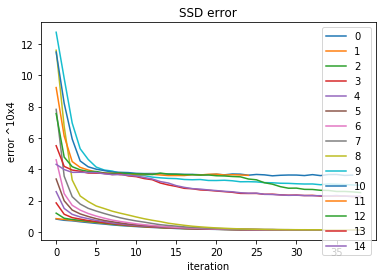

In [ ]:
axis = "x"
print(f"Pertubations arround axis {axis} errors")
plot_results(results_rotation_perturbations[axis], number_iterations=400, output_figure_name=f"rotation_pertubation_axis{axis}.pdf")

In [ ]:
axis = "x"
render_results(results_rotation_perturbations[axis])

Pertubations arround axis y errors


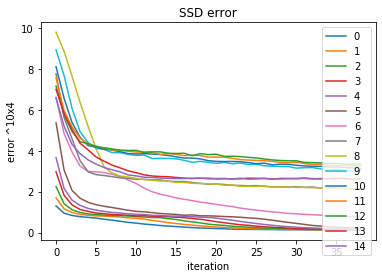

In [ ]:
axis = "y"
print(f"Pertubations arround axis {axis} errors")
plot_results(results_rotation_perturbations[axis], number_iterations=400, output_figure_name=f"rotation_pertubation_axis{axis}.pdf")

In [ ]:
axis="y"
render_results(results_rotation_perturbations[axis])

Pertubations arround axis z errors


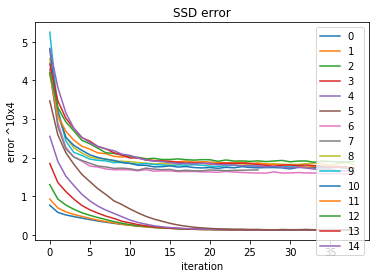

In [ ]:
axis = "z"
print(f"Pertubations arround axis {axis} errors")
plot_results(results_rotation_perturbations[axis], number_iterations=400, output_figure_name=f"rotation_pertubation_axis{axis}.pdf")

In [ ]:
axis="z"
render_results(results_rotation_perturbations[axis])

## Task 3: Run icp with different initial noise

In [ ]:
scale_factors = list(np.arange(0.01, 0.1, step=0.01)) + [0.1, 0.15, 0.2]

src_mesh = bunnies["bun045_v2"]["mesh"].copy()
dst_mesh = bunnies["bun000_v2"]["mesh"].copy()

translate_mesh_to_origin(src_mesh)
translate_mesh_to_origin(dst_mesh)

# Permutator.noise(dist) permutates each vertex up to dist away from it's initial rotation
mesh_permutator = trimesh.permutate.Permutator(src_mesh)

meshes = [ mesh_permutator.noise(src_mesh.scale * factor) for factor in scale_factors]
results_noise = [icp(dst_mesh, m, max_iterations=40) for m in meshes]

Error: 1.5678385685012304
Error: 0.7570288878449484
Error: 0.581222609766742
Error: 0.5110903842573787
Error: 0.4779237052817375
Error: 0.43526781463693803
Error: 0.405715223147535
Error: 0.37819770442706485
Error: 0.34681566863425706
Error: 0.317823355501651
Error: 0.2892336878745225
Error: 0.261552822566681
Error: 0.23770418156648143
Error: 0.21904416176282648
Error: 0.1996097523110299
Error: 0.18615074023575165
Error: 0.16843660169948388
Error: 0.15026334438025823
Error: 0.14007326480916354
Error: 0.12805024321788142
Error: 0.12081570187788741
Error: 0.11746902874531509
Error: 0.10938025404106912
Error: 0.10470095101639162
Error: 0.10074598995556946
Error: 0.09605400037423063
Error: 0.09516621470257473
Error: 0.09432379330207478
Error: 0.09247777446715007
Error: 0.08943201769311673
Error: 0.0855994112422304
Error: 0.08723628872096074
Error: 0.08759875192049013
Error: 0.08911680279901539
Error: 0.08777049763468596
Error: 0.08481662945870821
Error: 0.08549046530454088
Error: 0.0848922

Error: 0.2137973686376061
Error: 0.21542246267935858
Error: 0.2164725424216886
Error: 0.216971087179379
Error: 0.2128185839853101
Error: 0.2119665097369002
Error: 0.21451194216953987
Error: 0.21030972098427386
Error: 0.20747034495722846
Error: 0.21075275825910825
Error: 0.21288413466134362
Error: 1.7477853977362803
Error: 0.8526280973739553
Error: 0.6953760955951447
Error: 0.6371386610279608
Error: 0.6000128690810372
Error: 0.563098571635336
Error: 0.5421923297298763
Error: 0.5126528234171073
Error: 0.4907935779915939
Error: 0.4632994929702923
Error: 0.4448683430672857
Error: 0.419610991067297
Error: 0.40497853934862715
Error: 0.38152187717065295
Error: 0.36526978006568356
Error: 0.34974725775830046
Error: 0.33515967335661756
Error: 0.3178840091115314
Error: 0.307253248099026
Error: 0.30312834552269763
Error: 0.291145134345973
Error: 0.2824123535621888
Error: 0.28078412291889016
Error: 0.2742803374365323
Error: 0.2701726802909597
Error: 0.2686607486635439
Error: 0.26609178956140406
Err

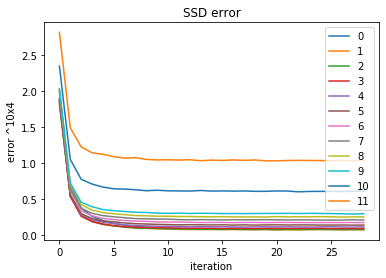

In [ ]:
plot_results(results_noise, 30, output_figure_name="noise_pertubations.pdf")

In [ ]:
render_results(results_noise)

## Task 4: Subsampling

## Run icp with all bunnies

* First a simple approach, match all bunnies to bun000_v2

In [ ]:
bunny_names = [
    #"bun000_v2",
    "bun045_v2",
    "bun090_v2",
    "bun180_v2",
    "bun270_v2",
    "bun315_v2"
]

meshes = [bunnies[name]["mesh"] for name in bunny_names]
results_all_bunnies_simple = [icp(bunnies["bun000_v2"]["mesh"], m, max_iterations=100) for m in meshes]

Error: 9.657896227080286
Error: 1.9116265230504648
Error: 0.8668653634589514
Error: 0.5961940405665157
Error: 0.4574400932839432
Error: 0.3661199439775291
Error: 0.2977654287191667
Error: 0.23925527528271112
Error: 0.2028723459609153
Error: 0.18208436212604814
Error: 0.16027375365011304
Error: 0.14517819745243027
Error: 0.14422019152748985
Error: 0.1478719279714507
Error: 0.14090709002096172
Error: 0.1393134887493747
Error: 0.14148214107705687
Error: 0.13756539578763108
Error: 0.1333368678008346
Error: 0.1355981025989052
Error: 0.1383067727922952
Error: 0.13833807014747437
Error: 0.13391842646808583
Error: 0.13560381459503437
Error: 0.13685476330760143
Error: 0.13549609314019478
Error: 0.1361493038073676
Error: 0.13753809535518915
Error: 0.1376049271189905
Error: 0.13590204795347707
Error: 0.13592202681804852
Error: 0.13846254400074282
Error: 0.136489073465318
Error: 0.13646802204705508
Error: 0.13589182502888858
Error: 0.13795199433615785
Error: 0.13722783828117377
Error: 0.1351342145

Error: 2.0150453144655742
Error: 2.0172278618931467
Error: 2.0228102456805552
Error: 2.0239200884477895
Error: 1.9999087152848625
Error: 1.9891252300446938
Error: 1.9802378144323531
Error: 2.0317572474858943
Error: 1.9871918310330268
Error: 1.9980735596368886
Error: 2.014433495415498
Error: 2.002775907997391
Error: 2.0074713199358887
Error: 2.020060790263502
Error: 2.0342144863027762
Error: 1.9938800544704223
Error: 2.0070884980403245
Error: 1.9928682935896824
Error: 1.995913208798145
Error: 2.0098488641232084
Error: 2.0096335427344356
Error: 2.0129829325991175
Error: 2.0010861023832134
Error: 2.0014658539953714
Error: 2.0220296213638105
Error: 2.004775120808064
Error: 1.9929485982966775
Error: 1.9733677976975035
Error: 1.9873192415791192
Error: 1.9924954264691175
Error: 2.0144457130144846
Error: 1.9861788789137396
Error: 2.0047097744589744
Error: 1.9972047009889495
Error: 1.9846057889680355
Error: 2.0011324176815024
Error: 1.9859405638952696
Error: 1.9953400573181594
Error: 2.01302452

In [ ]:
results_all_bunnies_simple = result_all_bunnies_simple
render_results(results_all_bunnies_simple)

In [ ]:
bunny_names = [
    #"bun000_v2",
    "bun045_v2",
    "bun090_v2",
    "bun180_v2",
    "bun270_v2",
    "bun315_v2"
]

meshes = [bunnies[name]["mesh"] for name in bunny_names]
results_all_bunnies_simple_point2plane = [icp(bunnies["bun000_v2"]["mesh"], m, max_iterations=10, method="p2plane") for m in meshes]

Error: 9.694518557372085
Error: 2.718787655351655
Error: 1.3853607545360043
Error: 0.668600121970357
Error: 0.24286750795229448
Error: 0.16857763833318792
Error: 0.17109293877120063
Error: 0.17204804534712143
Error: 0.17862833288543223
Error: 0.17565997506409767
Error: 7.597385289023364
Error: 3.2506719091828007
Error: 2.518941844377463
Error: 2.441622893076899
Error: 2.3148819284799704
Error: 2.16586505394839
Error: 2.060114617234868
Error: 2.078976627254225
Error: 2.0769614139623127
Error: 2.148423050186612
Error: 9.532608165506305
Error: 4.655593870037262
Error: 3.229257789013439
Error: 2.370551245999006
Error: 2.1397187097391397
Error: 2.248871949849926
Error: 2.423399894650689
Error: 2.626890627929823
Error: 2.7881435246709088
Error: 2.9031974876935958
Error: 8.90327447919296
Error: 2.5064841552547525
Error: 2.438850539347422
Error: 2.385669464194257
Error: 2.4295812542388546
Error: 2.5214010156166475
Error: 2.5879783700775323
Error: 2.7257795093504376
Error: 2.843354936033425
Err

In [ ]:
render_results(results_all_bunnies_simple_point2plane)

* Match all bunnies to closest first

In [ ]:
bunny_names = [
    "bun000_v2",
    "bun045_v2",
    "bun090_v2",
    "bun180_v2",
    "bun270_v2",
    "bun315_v2"
]
bunny_names
meshes = [bunnies[name]["mesh"] for name in bunny_names]


all_results = []
for i in range(5):
    src_mesh = meshes.pop()
    dst_mesh = meshes[-1]
    src_name = bunny_names.pop()
    dst_name = bunny_names[-1]
    
    print(f"Matching {src_name} to {dst_name}");
    results = icp(dst_mesh, src_mesh,
             max_iterations=300, 
             early_stop_iterations=10,
             method="p2point")
    all_results.append(results)
    
    meshes.append(results["best_matching_mesh"])
    bunny_names.append(src_name)
    
    

Matching bun315_v2 to bun270_v2
Error: 2.3589843296718658
Error: 2.0072259226486038
Error: 1.7417309644131889
Error: 1.5813012186027493
Error: 1.4299660364652158
Error: 1.3029366826317674
Error: 1.1940634891611501
Error: 1.1179271057802493
Error: 1.0625898733297874
Error: 1.0294880308615961
Error: 0.9901442552229887
Error: 0.9726207974726796
Error: 0.9670249008369921
Error: 0.9589941565316689
Error: 0.9550393286587491
Error: 0.9474110078533575
Error: 0.9491329074538396
Error: 0.9385023401345296
Error: 0.9300656186548975
Error: 0.9262225048527114
Error: 0.9204065627285952
Error: 0.9186455392034277
Error: 0.9348716173695779
Error: 0.9254495824332238
Error: 0.9289718434507603
Error: 0.9223140701640972
Error: 0.9248343003277316
Error: 0.9167467192449749
Error: 0.9212160069752886
Error: 0.9280365311261003
Error: 0.9136679014665718
Error: 0.9199834361547286
Error: 0.9230286376820513
Error: 0.9275952788018827
Error: 0.9141903788875385
Error: 0.924699143195098
Error: 0.9137364380246449
Error: 

## Task 5

The strategy chosen to match the bunnies is to sort them based on how close each bunny is to each other and put them into a queue.

Each time we dequeue a bunny and try to match it with the bunny next in the queue. That way bunnies that are close together are always attempted to match than trying to match bunnies that are further away.

### Example

In [ ]:
from collections import deque

bunny_names = [
    "bun000_v2",
    "bun045_v2",
    "bun090_v2",
    "bun180_v2",
    "bun270_v2",
    "bun315_v2"
]
bunny_names.reverse()
name_queue = deque(bunny_names)

for i in range(10):
    src_name = name_queue.popleft()
    dst_name = list(name_queue)[0]
    print(f"Matching {src_name} to {dst_name}");
    
    name_queue.append(src_name)

name_queue = deque(bunny_names)

Matching bun315_v2 to bun270_v2
Matching bun270_v2 to bun180_v2
Matching bun180_v2 to bun090_v2
Matching bun090_v2 to bun045_v2
Matching bun045_v2 to bun000_v2
Matching bun000_v2 to bun315_v2
Matching bun315_v2 to bun270_v2
Matching bun270_v2 to bun180_v2
Matching bun180_v2 to bun090_v2
Matching bun090_v2 to bun045_v2


## Implementation

**I could not implement the sorting.** The sorting was assumed as known based on seing the meshes.

In [ ]:
from collections import deque

bunny_names = [
    "bun000_v2",
    "bun045_v2",
    "bun090_v2",
    "bun180_v2",
    "bun270_v2",
    "bun315_v2"
]

bunny_names.reverse()
meshes = [ bunnies[name]["mesh"] for name in bunny_names]

for m in meshes:
    translate_mesh_to_origin(m)

name_queue = deque(bunny_names)
mesh_queue = deque(meshes)

all_results = []
for i in range(20):
    src_name = name_queue.popleft()
    dst_name = list(name_queue)[0]
    
    src_mesh = mesh_queue.popleft()
    dst_mesh = list(mesh_queue)[0]
    
    print(f"Matching {src_name} to {dst_name}");
    results = icp(dst_mesh, src_mesh,
             distance_threshold = 0.02,
             max_iterations=100, 
             early_stop_iterations=10,
             method="p2point")
    all_results.append(results)
    
    name_queue.append(src_name)

    new_src_mesh = results["best_matching_mesh"]
    mesh_queue.append(new_src_mesh)
    
    if ((i+1) % (len(bunny_names)-1) == 0) and i > 0:
        tmp = name_queue.popleft()
        name_queue.append(m)
        
        tmp = mesh_queue.popleft()
        mesh_queue.append(tmp)
    
    

Matching bun315_v2 to bun270_v2
Error: 2.3774501026567734
Error: 1.9931755498193056
Error: 1.761660163252537
Error: 1.5814474106302887
Error: 1.4330209815092112
Error: 1.3132072939320958
Error: 1.2005825869792393
Error: 1.141919457957798
Error: 1.0635954997431027
Error: 1.0380519528653895
Error: 1.0100733829044328
Error: 0.9911030455291059
Error: 0.9702003819358033
Error: 0.9743764372382375
Error: 0.948773281080236
Error: 0.9524855116650665
Error: 0.9432703895040572
Error: 0.9406633147834335
Error: 0.9285979941894601
Error: 0.9271988862793451
Error: 0.9241333294073842
Error: 0.9252614619963013
Error: 0.9169047023431364
Error: 0.9162629673225913
Error: 0.9194441218290059
Error: 0.9233601766212234
Error: 0.9266556605635026
Error: 0.927097613639885
Error: 0.922901762713509
Error: 0.9191225156058049
Error: 0.9166531056601872
Error: 0.922493624404658
Error: 0.925895887780875
Matching bun270_v2 to bun180_v2
Error: 14.076887327946883
Error: 4.486578571241321
Error: 3.389846397076235
Error: 3.

Error: 2.0476316742828704
Error: 2.076855837437058
Error: 2.036183821198812
Error: 2.0329826703598464
Error: 2.020126503970537
Error: 1.9937011000344418
Error: 1.982375053755601
Error: 1.9418997984086728
Error: 1.9247453995731718
Error: 1.8781366738905687
Error: 1.8155258422265061
Error: 1.794683659071659
Error: 1.7323484900808561
Error: 1.6869585665931124
Error: 1.6532144315796322
Error: 1.5907571943591692
Error: 1.54467437575549
Error: 1.489711083095813
Error: 1.4760694372546734
Error: 1.441230077583294
Error: 1.433487100919048
Error: 1.396805253485069
Error: 1.3794232343848478
Error: 1.378685931541107
Error: 1.3637903795535318
Error: 1.3617090267395155
Error: 1.3350879873167532
Error: 1.3422713047776276
Error: 1.3358423585426213
Error: 1.3150237651698968
Error: 1.326068903918427
Error: 1.3225717163357489
Error: 1.3164973913005666
Error: 1.3226042356020826
Error: 1.3139475793154611
Error: 1.2949267422839936
Error: 1.2705844720864927
Error: 1.2096809066395997
Error: 1.0375617718473202

Error: 0.7590374717257058
Error: 0.6842484437619916
Error: 0.6372063497544858
Error: 0.5769950358746017
Error: 0.5162992022554223
Error: 0.46495673835318996
Error: 0.4202546415034814
Error: 0.38400320616795947
Error: 0.3469384921539244
Error: 0.3175829302538303
Error: 0.2899406084899491
Error: 0.2608042076831637
Error: 0.23415023463820686
Error: 0.21633458199501265
Error: 0.2009441171812911
Error: 0.18488266430014397
Error: 0.171464294434866
Error: 0.1593536673797947
Error: 0.1552950393096043
Error: 0.1454069881725529
Error: 0.14152118844350767
Error: 0.13907801829449223
Error: 0.13315790020638668
Error: 0.13315887204055135
Error: 0.13212787605855855
Error: 0.13145575189212638
Error: 0.1305151376002896
Error: 0.12662144237677186
Error: 0.1290915825175135
Error: 0.12378739715044854
Error: 0.12563541585805976
Error: 0.12262829309299991
Error: 0.1254542881189562
Error: 0.12416589853962198
Error: 0.1242126592571681
Error: 0.12693795413246375
Error: 0.12345432852033598
Error: 0.123945290596

## Demo

In [ ]:
file_names = [
    "bun045_v2",
    "bun045_v2_tx",
    "bun270_v2",
    "bun315_v2"
]

meshes = [ trimesh.load(f"./data/demo/{name}.ply") for name in file_names]
point_clouds = [mesh.vertices for mesh in meshes]
render_objects = [pyrender.Mesh.from_points(pcd, colors=(np.random.rand(),np.random.rand(),np.random.rand())) for pcd in point_clouds]

bunnies = {}

for i, name in enumerate(file_names):
    bunnies[name] = {"mesh":meshes[i], "vertices":point_clouds[i], "render_object":render_objects[i]}


In [ ]:
dst_mesh = bunnies["bun045_v2"]["mesh"]
src_mesh = bunnies["bun045_v2_tx"]["mesh"]
results = icp(dst_mesh, src_mesh,
         max_iterations=100,
         distance_threshold = 0.02, 
         early_stop_iterations=10,
         method="p2point")

Rejected 199 indices
Pshape(39801, 3) Qshape(39801, 3)
Error: 0.5431953611237342
Rejected 2 indices
Pshape(39998, 3) Qshape(39998, 3)
Error: 0.2718496172418809
Rejected 0 indices
Pshape(40000, 3) Qshape(40000, 3)
Error: 0.17582171195124102
Rejected 1 indices
Pshape(39999, 3) Qshape(39999, 3)
Error: 0.1392089442829056
Rejected 3 indices
Pshape(39997, 3) Qshape(39997, 3)
Error: 0.12022361827050752
Rejected 7 indices
Pshape(39993, 3) Qshape(39993, 3)
Error: 0.10966721138541025
Rejected 10 indices
Pshape(39990, 3) Qshape(39990, 3)
Error: 0.10141408046976959
Rejected 23 indices
Pshape(39977, 3) Qshape(39977, 3)
Error: 0.09660499374245014
Rejected 21 indices
Pshape(39979, 3) Qshape(39979, 3)
Error: 0.0927807618033933
Rejected 25 indices
Pshape(39975, 3) Qshape(39975, 3)
Error: 0.08505848863983793
Rejected 35 indices
Pshape(39965, 3) Qshape(39965, 3)
Error: 0.08866112158629195
Rejected 36 indices
Pshape(39964, 3) Qshape(39964, 3)
Error: 0.08691589998272137
Rejected 26 indices
Pshape(39974, 3)

In [ ]:
render_results(results)

In [ ]:
render_meshes(meshes[0:2])

In [ ]:
bunny_names = [
    "bun045_v2",
    "bun045_v2_tx",
    "bun270_v2",
    "bun315_v2"
]
bunny_names.reverse()
name_queue = deque(bunny_names)

for i in range(20):
    src_name = name_queue.popleft()
    dst_name = list(name_queue)[0]
    print(f"Matching {src_name} to {dst_name}");
    
    name_queue.append(src_name)

    if ((i+1) % (len(bunny_names)-1) == 0) and i > 0:
        print("starting over")
        m = name_queue.popleft()
        name_queue.append(m)

name_queue = deque(bunny_names)

Matching bun315_v2 to bun270_v2
Matching bun270_v2 to bun045_v2_tx
Matching bun045_v2_tx to bun045_v2
starting over
Matching bun315_v2 to bun270_v2
Matching bun270_v2 to bun045_v2_tx
Matching bun045_v2_tx to bun045_v2
starting over
Matching bun315_v2 to bun270_v2
Matching bun270_v2 to bun045_v2_tx
Matching bun045_v2_tx to bun045_v2
starting over
Matching bun315_v2 to bun270_v2
Matching bun270_v2 to bun045_v2_tx
Matching bun045_v2_tx to bun045_v2
starting over
Matching bun315_v2 to bun270_v2
Matching bun270_v2 to bun045_v2_tx
Matching bun045_v2_tx to bun045_v2
starting over
Matching bun315_v2 to bun270_v2
Matching bun270_v2 to bun045_v2_tx
Matching bun045_v2_tx to bun045_v2
starting over
Matching bun315_v2 to bun270_v2
Matching bun270_v2 to bun045_v2_tx


In [ ]:
bunny_names = [
    "bun045_v2",
    "bun045_v2_tx",
    "bun270_v2",
    "bun315_v2"
]

bunny_names.reverse()
meshes = [ bunnies[name]["mesh"] for name in bunny_names]

for m in meshes:
    translate_mesh_to_origin(m)

name_queue = deque(bunny_names)
mesh_queue = deque(meshes)

all_results = []
for i in range(20):
    src_name = name_queue.popleft()
    dst_name = list(name_queue)[0]
    
    src_mesh = mesh_queue.popleft()
    dst_mesh = list(mesh_queue)[0]
    
    print(f"Matching {src_name} to {dst_name}");
    results = icp(dst_mesh, src_mesh,
             distance_threshold = 0.02,
             max_iterations=100, 
             early_stop_iterations=10,
             method="p2point")
    all_results.append(results)
    
    name_queue.append(src_name)

    new_src_mesh = results["best_matching_mesh"]
    mesh_queue.append(new_src_mesh)
    
    if ((i+1) % (len(bunny_names)-1) == 0) and i > 0:
        tmp = name_queue.popleft()
        name_queue.append(m)
        
        tmp = mesh_queue.popleft()
        mesh_queue.append(tmp)
    

Matching bun315_v2 to bun270_v2
Error: 2.292128313943511
Error: 1.886710037950625
Error: 1.6212980676326205
Error: 1.4655165185819998
Error: 1.328660761680194
Error: 1.2273658454299432
Error: 1.1312771581561958
Error: 1.0812567048580903
Error: 1.047259097878063
Error: 0.9915446583117075
Error: 0.9860328674417562
Error: 0.9692840007805776
Error: 0.9710186072385554
Error: 0.9549839134492447
Error: 0.9266129191484334
Error: 0.9428463099044753
Error: 0.9424917758191372
Error: 0.9347523894843173
Error: 0.9281843608071635
Error: 0.9250497101643039
Error: 0.9344350480968642
Error: 0.917200133504741
Error: 0.9437809965361718
Error: 0.9261359431363184
Error: 0.9226506147471965
Error: 0.916734090677375
Error: 0.915365280330744
Error: 0.9181481616137155
Error: 0.9216932539447442
Error: 0.9053373806225647
Error: 0.9124009065902375
Error: 0.9066828241722192
Error: 0.9260100122170041
Error: 0.9277233537668144
Error: 0.9156458054276101
Error: 0.9224030321344783
Error: 0.9261599190556373
Error: 0.9150

Error: 0.08176438930294352
Error: 0.0866213478546472
Error: 0.08207863949013026
Error: 0.08119231476685392
Error: 0.08217376412447813
Error: 0.08384178851831826
Error: 0.08271112801780048
Error: 0.08143645059715537
Matching bun315_v2 to bun270_v2
Error: 0.9612401462296286
Error: 0.9394357118114581
Error: 0.9203113889530486
Error: 0.9041756282222978
Error: 0.9259837941921791
Error: 0.9279386541628132
Error: 0.917359288424761
Error: 0.9160456989597142
Error: 0.904467008152518
Error: 0.9192809041420689
Error: 0.932533383252804
Error: 0.923929763005869
Error: 0.909840005963281
Matching bun270_v2 to bun045_v2_tx
Error: 1.4845801650786337
Error: 1.4662236000937199
Error: 1.4453591183956003
Error: 1.4651207838637523
Error: 1.4658038832047868
Error: 1.4734062182684282
Error: 1.4860334644403648
Error: 1.4641136716927945
Error: 1.4449261776186224
Error: 1.4767558619209613
Error: 1.493889115652338
Error: 1.4620939640248285
Error: 1.4822741848061625
Error: 1.4652530044270387
Error: 1.4577042274034

In [ ]:
render_results(all_results[1])